In [ ]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
## Librerias y cargar el Drive

import glob, os.path
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.metrics import f1_score
from scipy.stats import percentileofscore
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score #sensibilidad
from time import time
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import roc_curve,roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split




In [ ]:
## Cargar los datos
x_train = np.load("/clinicfs/userhomes/rtabares/isic2019/Train.npy")
y_train = np.load("/clinicfs/userhomes/rtabares/isic2019/Label.npy")
x_test = np.load("/clinicfs/userhomes/rtabares/isic2019/Validation.npy")
y_test = np.load("/clinicfs/userhomes/rtabares/isic2019/Label_v.npy")

In [ ]:
x_train.shape

(56774, 150, 150, 3)

In [ ]:
y_train.shape

(56774,)

In [ ]:
x_test.shape

(12611, 150, 150, 3)

In [ ]:
y_test.shape

(12611,)

In [ ]:
## Normalizar los Datos
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /=255
x_test /=255


In [ ]:
y_train  = to_categorical(y_train, 8)
y_test = to_categorical(y_test, 8)

In [ ]:
y_train.shape

(56774, 8)

In [ ]:
y_test.shape

(12611, 8)

## Load Model DenseNet201

In [ ]:
pre_trained_model = tf.keras.applications.DenseNet201(
                    include_top=False,
                    weights= 'imagenet',
                    input_shape = (150, 150, 3)
                    )

In [ ]:
pre_trained_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
for layer in pre_trained_model.layers[:180]: #150
   layer.trainable = False
for layer in pre_trained_model.layers[180:]:
   layer.trainable = True

## Hidden Layer Design

In [ ]:
def get_model():
  inputs = tf.keras.Input(shape=(150, 150, 3))

  x = pre_trained_model(inputs)

  layers = tf.keras.layers.GlobalAveragePooling2D()(x)
  #layers = Flatten(name="flatten")(x)

  #Hidden Layers
  layers = Dense(512)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)

  layers = Dense(128)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)


  layers = Dense(64)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)


  layers = Dense(32)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)

  #classification layer
  predictions = Dense(8, activation="softmax", name="output_1")(layers)
  model = Model(inputs = inputs, outputs=predictions)


  return model

In [ ]:
modelFT = get_model()
modelFT.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664 

In [ ]:

DESIRED_ACCURACY = 0.999
INIT_LR = 1e-3
def exp_decay(epoch):
  initial_lrate = 1e-3
  k = 0.095
  lrate = initial_lrate * np.exp(-k*epoch)
  return lrate



class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.lr = []

  def on_epoch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.lr.append(exp_decay(len(self.losses)))

class end_train(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,log={}):
            if log.get('val_accuracy')>DESIRED_ACCURACY:
                print("\nReached"+str(DESIRED_ACCURACY)+"% val_accuracy so cancelling training!")
                self.model.stop_training = True
end_t = end_train()
loss_history = LossHistory()
lrate = LearningRateScheduler(exp_decay)       
callbacks_list = [loss_history,lrate,end_t]

callbacks=callbacks_list

In [ ]:
## Optimizer
modelFT.compile(
    optimizer="Adamax",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )

## Train Model

In [ ]:
tiempo_inicial = time()

In [ ]:
history = modelFT.fit(x=x_train, y=y_train, batch_size=128, epochs=33, verbose=1, validation_data=(x_test, y_test), validation_batch_size=128 , shuffle=True, callbacks=callbacks)  

Epoch 1/33
444/444 [==============================] - 3131s 7s/step - loss: 0.9542 - accuracy: 0.6822 - val_loss: 0.6548 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 2/33
444/444 [==============================] - 3111s 7s/step - loss: 0.4689 - accuracy: 0.8417 - val_loss: 0.4834 - val_accuracy: 0.8341 - lr: 9.0937e-04
Epoch 3/33
444/444 [==============================] - 3119s 7s/step - loss: 0.2707 - accuracy: 0.9100 - val_loss: 0.4026 - val_accuracy: 0.8604 - lr: 8.2696e-04
Epoch 4/33
444/444 [==============================] - 3108s 7s/step - loss: 0.1584 - accuracy: 0.9482 - val_loss: 0.3301 - val_accuracy: 0.8912 - lr: 7.5201e-04
Epoch 5/33
444/444 [==============================] - 3125s 7s/step - loss: 0.0938 - accuracy: 0.9697 - val_loss: 0.3316 - val_accuracy: 0.8949 - lr: 6.8386e-04
Epoch 6/33
444/444 [==============================] - 2762s 6s/step - loss: 0.0546 - accuracy: 0.9836 - val_loss: 0.3302 - val_accuracy: 0.9038 - lr: 6.2189e-04
Epoch 7/33
444/444 [==================

## Results

In [ ]:

acc = history.history[ 'accuracy' ] # con drop
val_acc = history.history[ 'val_accuracy' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
lr = history.history['lr' ]
epochs = range(1,len(acc)+1,1)


In [ ]:
acc

[0.6821608543395996,
 0.8417409658432007,
 0.9100116491317749,
 0.9481629133224487,
 0.9697044491767883,
 0.983566403388977,
 0.9899425506591797,
 0.9928135871887207,
 0.996036946773529,
 0.9978159070014954,
 0.9980624914169312,
 0.998590886592865,
 0.9993835091590881,
 0.9992250204086304,
 0.9997005462646484,
 0.999859094619751,
 0.999718189239502,
 0.9997886419296265,
 0.999911904335022,
 0.9999647736549377,
 0.9998766779899597,
 0.9999295473098755,
 0.9999471306800842,
 0.9999823570251465,
 0.9999647736549377,
 1.0,
 0.9999471306800842,
 0.9999647736549377,
 0.9999823570251465,
 0.9999823570251465,
 0.9999823570251465,
 0.9999647736549377,
 0.9999823570251465]

In [ ]:
val_acc

[0.7868527770042419,
 0.8341130614280701,
 0.8604393005371094,
 0.8912060856819153,
 0.8948537111282349,
 0.9038141369819641,
 0.9099991917610168,
 0.9138054251670837,
 0.921497106552124,
 0.9218935966491699,
 0.9244310259819031,
 0.9208627343177795,
 0.9260169863700867,
 0.9290302395820618,
 0.9277614951133728,
 0.9299024939537048,
 0.9291887879371643,
 0.9304575324058533,
 0.9308540225028992,
 0.9313297867774963,
 0.932519257068634,
 0.9309332966804504,
 0.9305368065834045,
 0.9322813153266907,
 0.9306161403656006,
 0.9322813153266907,
 0.932519257068634,
 0.9321227669715881,
 0.9320434331893921,
 0.9321227669715881,
 0.932439923286438,
 0.9325985312461853,
 0.9332329034805298]

In [ ]:
loss

[0.9542335867881775,
 0.46892815828323364,
 0.27072635293006897,
 0.15841691195964813,
 0.09376253187656403,
 0.05461625009775162,
 0.03474020957946777,
 0.024366192519664764,
 0.015445549972355366,
 0.009671573527157307,
 0.008126234635710716,
 0.005878739058971405,
 0.0037387474440038204,
 0.0037661606911569834,
 0.0021821886766701937,
 0.001406280673108995,
 0.0015891646035015583,
 0.001591467414982617,
 0.00101399642881006,
 0.0007706037140451372,
 0.0009139709291048348,
 0.0006754130590707064,
 0.0006081303581595421,
 0.0005006553255952895,
 0.0005068639875389636,
 0.0004094421456102282,
 0.00047758713481016457,
 0.0004043726366944611,
 0.00034912029514089227,
 0.0003472405078355223,
 0.00034947466338053346,
 0.0003290233726147562,
 0.0002899937971960753]

In [ ]:
val_loss

[0.6548464298248291,
 0.4833882451057434,
 0.4026441276073456,
 0.3300725817680359,
 0.33162322640419006,
 0.33023107051849365,
 0.31118616461753845,
 0.3235887587070465,
 0.29806452989578247,
 0.30456334352493286,
 0.308719664812088,
 0.3192156255245209,
 0.30704793334007263,
 0.29796484112739563,
 0.30333074927330017,
 0.2994067668914795,
 0.3123617470264435,
 0.30864542722702026,
 0.31740644574165344,
 0.31561946868896484,
 0.30993470549583435,
 0.3159791827201843,
 0.3157418370246887,
 0.31491583585739136,
 0.3210776448249817,
 0.3217463791370392,
 0.3218962252140045,
 0.32354503870010376,
 0.32445594668388367,
 0.32772761583328247,
 0.3270556330680847,
 0.33029791712760925,
 0.33106720447540283]

In [ ]:
## Save Model
modelFT.save("/clinicfs/userhomes/rtabares/isic2019/modelo_Densenet201.h5")

In [ ]:
## Load Model
modelFT = load_model("/clinicfs/userhomes/rtabares/isic2019/modelo_Densenet201.h5")

In [ ]:
acc =  [0.6821608543395996,
 0.8417409658432007,
 0.9100116491317749,
 0.9481629133224487,
 0.9697044491767883,
 0.983566403388977,
 0.9899425506591797,
 0.9928135871887207,
 0.996036946773529,
 0.9978159070014954,
 0.9980624914169312,
 0.998590886592865,
 0.9993835091590881,
 0.9992250204086304,
 0.9997005462646484,
 0.999859094619751,
 0.999718189239502,
 0.9997886419296265,
 0.999911904335022,
 0.9999647736549377,
 0.9998766779899597,
 0.9999295473098755,
 0.9999471306800842,
 0.9999823570251465,
 0.9999647736549377,
 1.0,
 0.9999471306800842,
 0.9999647736549377,
 0.9999823570251465,
 0.9999823570251465,
 0.9999823570251465,
 0.9999647736549377,
 0.9999823570251465]

In [ ]:
val_acc = [0.7868527770042419,
 0.8341130614280701,
 0.8604393005371094,
 0.8912060856819153,
 0.8948537111282349,
 0.9038141369819641,
 0.9099991917610168,
 0.9138054251670837,
 0.921497106552124,
 0.9218935966491699,
 0.9244310259819031,
 0.9208627343177795,
 0.9260169863700867,
 0.9290302395820618,
 0.9277614951133728,
 0.9299024939537048,
 0.9291887879371643,
 0.9304575324058533,
 0.9308540225028992,
 0.9313297867774963,
 0.932519257068634,
 0.9309332966804504,
 0.9305368065834045,
 0.9322813153266907,
 0.9306161403656006,
 0.9322813153266907,
 0.932519257068634,
 0.9321227669715881,
 0.9320434331893921,
 0.9321227669715881,
 0.932439923286438,
 0.9325985312461853,
 0.9332329034805298]

In [ ]:
loss = [0.9542335867881775,
 0.46892815828323364,
 0.27072635293006897,
 0.15841691195964813,
 0.09376253187656403,
 0.05461625009775162,
 0.03474020957946777,
 0.024366192519664764,
 0.015445549972355366,
 0.009671573527157307,
 0.008126234635710716,
 0.005878739058971405,
 0.0037387474440038204,
 0.0037661606911569834,
 0.0021821886766701937,
 0.001406280673108995,
 0.0015891646035015583,
 0.001591467414982617,
 0.00101399642881006,
 0.0007706037140451372,
 0.0009139709291048348,
 0.0006754130590707064,
 0.0006081303581595421,
 0.0005006553255952895,
 0.0005068639875389636,
 0.0004094421456102282,
 0.00047758713481016457,
 0.0004043726366944611,
 0.00034912029514089227,
 0.0003472405078355223,
 0.00034947466338053346,
 0.0003290233726147562,
 0.0002899937971960753]

In [ ]:
val_loss = [0.6548464298248291,
 0.4833882451057434,
 0.4026441276073456,
 0.3300725817680359,
 0.33162322640419006,
 0.33023107051849365,
 0.31118616461753845,
 0.3235887587070465,
 0.29806452989578247,
 0.30456334352493286,
 0.308719664812088,
 0.3192156255245209,
 0.30704793334007263,
 0.29796484112739563,
 0.30333074927330017,
 0.2994067668914795,
 0.3123617470264435,
 0.30864542722702026,
 0.31740644574165344,
 0.31561946868896484,
 0.30993470549583435,
 0.3159791827201843,
 0.3157418370246887,
 0.31491583585739136,
 0.3210776448249817,
 0.3217463791370392,
 0.3218962252140045,
 0.32354503870010376,
 0.32445594668388367,
 0.32772761583328247,
 0.3270556330680847,
 0.33029791712760925,
 0.33106720447540283]

In [ ]:
epochs = range(1, 34)

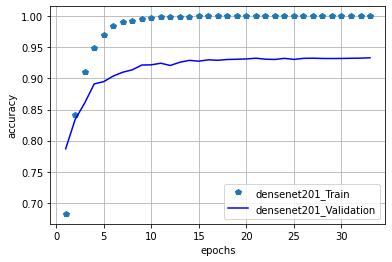

In [ ]:
plt.grid(True)
plt.plot (epochs, acc, 'p', label='densenet201_Train')
plt.plot (epochs, val_acc, 'b', label='densenet201_Validation')


#plt.title ('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
#plt.savefig('/content/Drive/MyDrive/imágenes convertidas a formato eps/experimento3_accuracy.eps', format='eps')
plt.show()

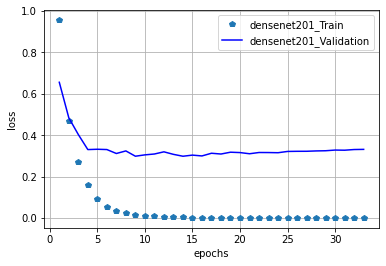

In [ ]:
plt.grid(True)


plt.plot (epochs, loss, 'p', label='densenet201_Train')
plt.plot (epochs, val_loss, 'b', label='densenet201_Validation')


#plt.title ('Training and validation accuracy')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
#plt.savefig('/content/Drive/MyDrive/imágenes convertidas a formato eps/experimento3_loss.eps', format='eps')

In [ ]:
X_test = np.load("/clinicfs/userhomes/rtabares/isic2019/x_test.npy")

y_test = np.load("/clinicfs/userhomes/rtabares/isic2019/y_test.npy")


In [ ]:
## Normalizar los Datos
X_test = X_test.astype('float32')
X_test /=255

In [ ]:
y_test = to_categorical(y_test, 8)

In [ ]:
X_test.shape

(6303, 150, 150, 3)

In [ ]:
y_test.shape

(6303, 8)

In [ ]:
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7])

In [ ]:
y_test.shape

(6303, 8)

In [ ]:
pred = modelFT.predict(X_test, batch_size=32, verbose=1)  
predicted = np.argmax(pred, axis=1)

197/197 [==============================] - 62s 316ms/step


In [ ]:
target_names = ["class 0", "class 1", "class 2", "class 3", "class 4", "class 5", "class 6", "class 7"]

In [ ]:
labels = np.argmax(y_test, axis=1)

In [ ]:
pre = np.array(predicted)
labe = np.array(labels)

In [ ]:
true = labe
pred2 = np.copy(predicted)
labels = np.arange(8)
target_names = list(range(8))

In [ ]:
clf_report = classification_report(true,
                                   pred2,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

In [ ]:
f1_score(labe, pred2, average='micro')

0.9300333174678724

<AxesSubplot:>

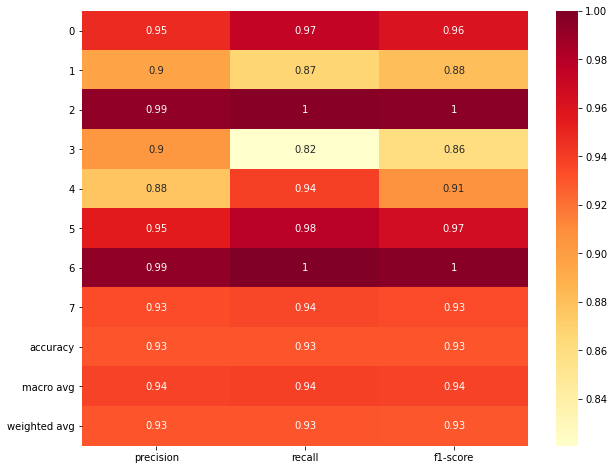

In [ ]:
plt.figure(figsize = (10,8))  
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap='YlOrRd',linecolor='red')
#plt.savefig('/content/Drive/MyDrive/ProyectoCafé/Imagenes_metricas/experimento4_densenet201_metricas', format='eps')

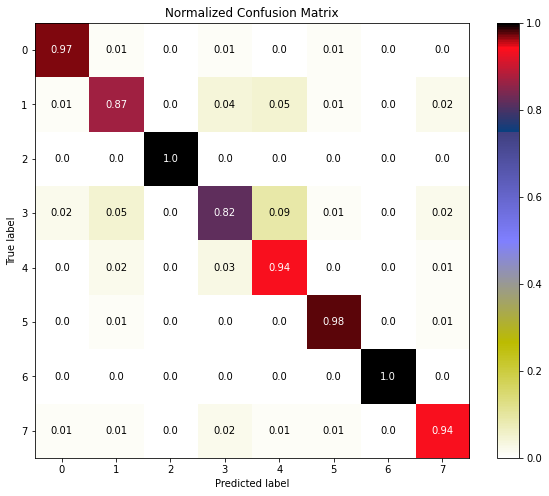

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(labe, pred2, normalize=True,cmap='gist_stern_r',figsize=(10,8))
#plt.savefig('/content/Drive/MyDrive/ProyectoCafé/Imagenes_metricas/experimento4_densenet201_matriz', format='eps')
plt.show()

In [ ]:
# 7 Clases por Clasificar
n_classes = 8
#Grosor de la linea
lw = 2

In [ ]:
pred2 = label_binarize(predicted , classes=[0,1,2,3,4,5,6,7])

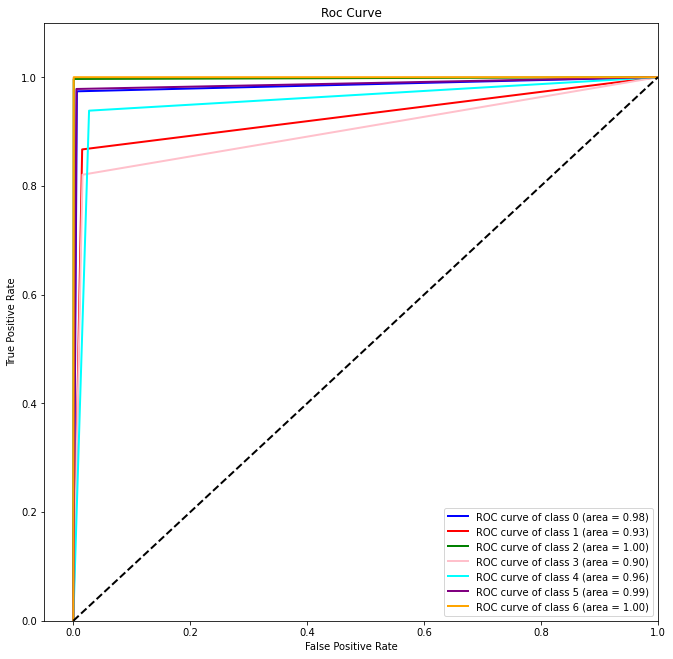

In [ ]:
fpr = dict()
tpr = dict()
roc_auc2 = dict()
plt.figure(figsize = (11,11))  
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve( y_test[:, i], pred2[:, i])
    roc_auc2[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green','pink','cyan','purple','orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('/content/Drive/MyDrive/ProyectoCafé/Imagenes_metricas/experimento2_vgg16_matriz', format='eps')

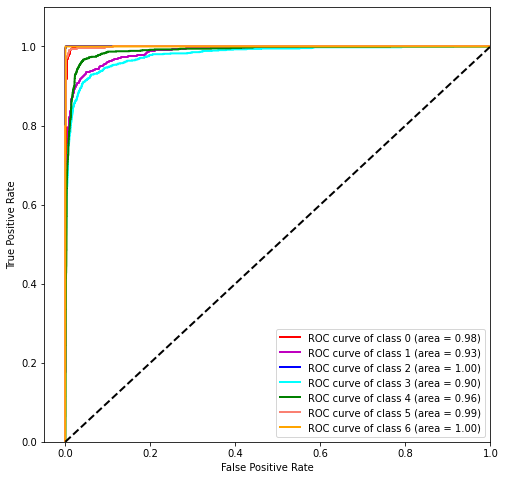

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize = (8,8))  
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve( y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['red','m', 'blue', 'cyan', 'green', 'salmon', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

#plt.savefig('/content/Drive/MyDrive/ProyectoCafé/Imagenes_metricas/experimento4_densenet201_roc', format='eps')